# Visualize Experiment Results - Imputation Performance

This notebook should answer the questions: *Which imputer works best to re-construct missing values?*

## Notebook Structure 

* Application Scenario 1 - Imputation Performance 
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [31]:
EXPERIMENT_PATH = Path("../data/experiments/cluster5/fully_observed/")
FIGURES_PATH = Path("../paper/figures//fully_observed/")

CLF_METRIC = "F1_macro"
REG_METRIC = "RMSE"

IMPUTE_RESULT_TYPE = "impute_performance_mean"

CONFIDENCE_INTERVAL = 90

## Import the data

In [4]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 52s, sys: 6.02 s, total: 1min 58s
Wall time: 2min 8s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,MAE,1.179853,1.120607,NaN,NaN,NaN
1,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,MSE,23.152042,10.959723,NaN,NaN,NaN
2,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,1.425468,0.630841,NaN,NaN,NaN
3,fully_observed,AutoKerasImputer,40922,MAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.905889,0.471882,NaN,NaN,NaN
4,fully_observed,AutoKerasImputer,40922,MAR,0.30,single_all,gyro_y,impute_performance_std,MSE,13.756370,17.497516,NaN,NaN,NaN


In [5]:
impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]
assert len(results["strategy"].unique()) == 1
impute_results.drop(["experiment", "train", "strategy", "baseline", "corrupted", "imputed"], axis=1, inplace=True) 
impute_results = impute_results.rename(
    {
        "imputer": "Imputer",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "test": "Imputation"
    },
    axis = 1
)
impute_results.head()

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation
17048,AutoKerasImputer,40922,MAR,0.01,gyro_y,impute_performance_mean,RMSE,8.598598
17051,AutoKerasImputer,40922,MAR,0.30,gyro_y,impute_performance_mean,RMSE,8.497674
17054,AutoKerasImputer,40922,MAR,0.50,gyro_y,impute_performance_mean,RMSE,9.750014
17057,AutoKerasImputer,40922,MAR,0.10,gyro_y,impute_performance_mean,RMSE,7.729013
17060,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_mean,RMSE,7.997631


## Compute Imputer Ranking

In [6]:
EXPERIMENTAL_CONDITIONS = ["Task", "Missing Type", "Missing Fraction", "Column", "result_type", "metric"]

clf_row_idx = results["metric"] == CLF_METRIC
reg_row_idx = results["metric"] == REG_METRIC

In [7]:
impute_results.loc[clf_row_idx, "Imputation Rank"] = impute_results[clf_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=False, na_option="bottom", method="min")["Imputation"]
impute_results.loc[reg_row_idx, "Imputation Rank"] = impute_results[reg_row_idx].groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=True, na_option="bottom", method="min")["Imputation"]
impute_results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation,Imputation Rank
17048,AutoKerasImputer,40922,MAR,0.01,gyro_y,impute_performance_mean,RMSE,8.598598,3.0
17051,AutoKerasImputer,40922,MAR,0.30,gyro_y,impute_performance_mean,RMSE,8.497674,1.0
17054,AutoKerasImputer,40922,MAR,0.50,gyro_y,impute_performance_mean,RMSE,9.750014,1.0
17057,AutoKerasImputer,40922,MAR,0.10,gyro_y,impute_performance_mean,RMSE,7.729013,1.0
17060,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_mean,RMSE,7.997631,1.0
...,...,...,...,...,...,...,...,...,...
34079,GAINImputer,1220,MCAR,0.10,keyword_id,impute_performance_mean,RMSE,NaN,7.0
34082,GAINImputer,1220,MNAR,0.01,keyword_id,impute_performance_mean,RMSE,NaN,7.0
34085,GAINImputer,1220,MNAR,0.30,keyword_id,impute_performance_mean,RMSE,NaN,7.0
34088,GAINImputer,1220,MNAR,0.50,keyword_id,impute_performance_mean,RMSE,NaN,7.0


### Check if results are complete

In [8]:
# should have equal length
impute_results["Imputer"].value_counts(dropna=False)

VAEImputer_noise    828
ModeImputer         828
KNNImputer          828
VAEImputer_0        828
GAINImputer         828
ForestImputer       819
AutoKerasImputer    723
Name: Imputer, dtype: int64

### Robustness: check which imputers yielded no results

In [9]:
for col in impute_results.columns:
    na_sum = impute_results[col].isna().sum()
    if na_sum > 0:
        print("-----" * 10)        
        print(col, na_sum)
        print("-----" * 10)        
        na_idx = impute_results[col].isna()
        print(impute_results.loc[na_idx, "Imputer"].value_counts(dropna=False))
        print("\n")

--------------------------------------------------
Imputation 276
--------------------------------------------------
GAINImputer         273
AutoKerasImputer      3
Name: Imputer, dtype: int64




### Check if the scores/ranks are normally distributed

Otherwise it might not make sense to show the standard deviations / confidence intervals it the plots below.

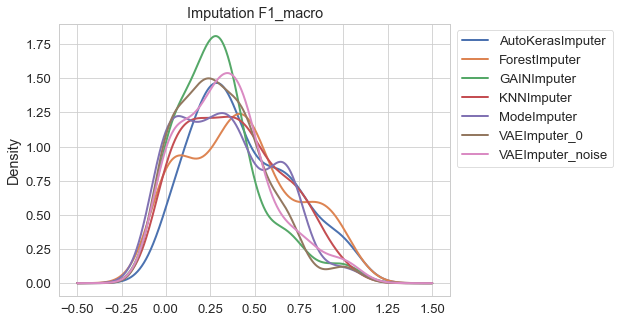

In [10]:
kde_data = impute_results.loc[clf_row_idx, ["Imputer", "Imputation"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation")

kde_data.plot(kind="kde", title=f"Imputation {CLF_METRIC}", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

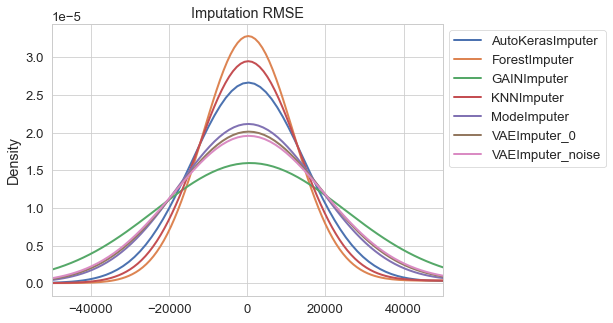

In [11]:
kde_data = impute_results.loc[reg_row_idx, ["Imputer", "Imputation"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation")

kde_data.plot(kind="kde", title=f"Imputation {REG_METRIC}", figsize=(7,5), xlim=(-50000, 50000))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

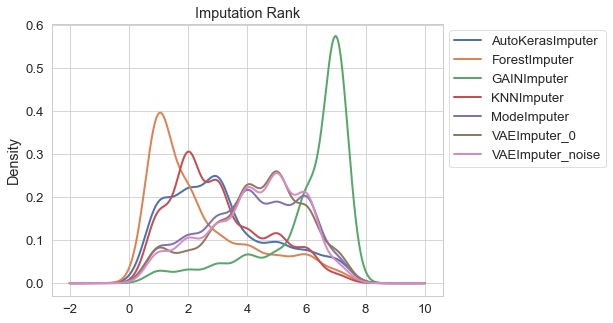

In [12]:
kde_data = impute_results[["Imputer", "Imputation Rank"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation Rank")

kde_data.plot(kind="kde", title="Imputation Rank", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

## Plotting Functions

In [23]:
def plot_metric_vs_missing_fraction(data, result_type, metric_names, y, ylabel, export_path, figure_name):
    row_idx = (data["result_type"] == result_type) & (data["metric"].isin(metric_names))
    plot_data = data[row_idx]
    
    plt.figure(figsize=(10,7))
    ax = sns.lineplot(
        data=plot_data, 
        x="Missing Fraction", 
        y=y, 
        hue="Imputer", 
        style="Imputer",
        ci=CONFIDENCE_INTERVAL
    )
    ax.set(ylabel=ylabel)
    ax.set_xticks(sorted(plot_data["Missing Fraction"].unique()))
    
    plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner 
    
    Path(export_path/result_type).mkdir(parents=True, exist_ok=True)    
    plt.savefig(export_path/result_type/f"{figure_name}.svg")

## Application Scenario 1 - Imputation Performance

### 1.1) Categorical Columns (Classification)

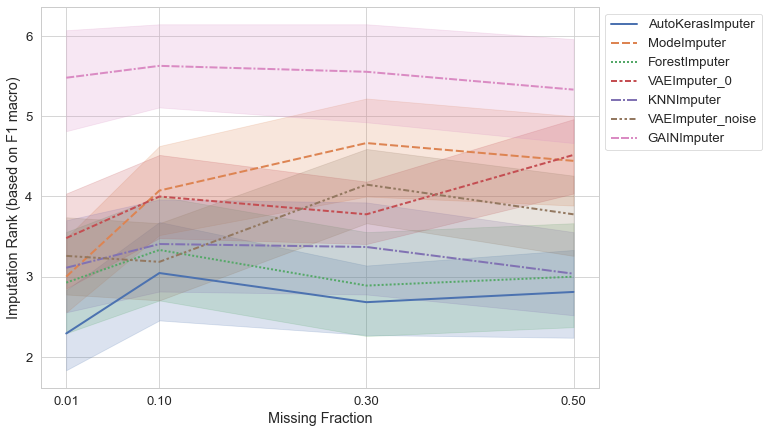

In [33]:
plot_metric_vs_missing_fraction(
    data = impute_results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [CLF_METRIC], 
    y = "Imputation Rank",
    ylabel = f"Imputation Rank (based on {CLF_METRIC.replace('_', ' ')})",
    export_path = FIGURES_PATH,
    figure_name = "categorical_rank"
)

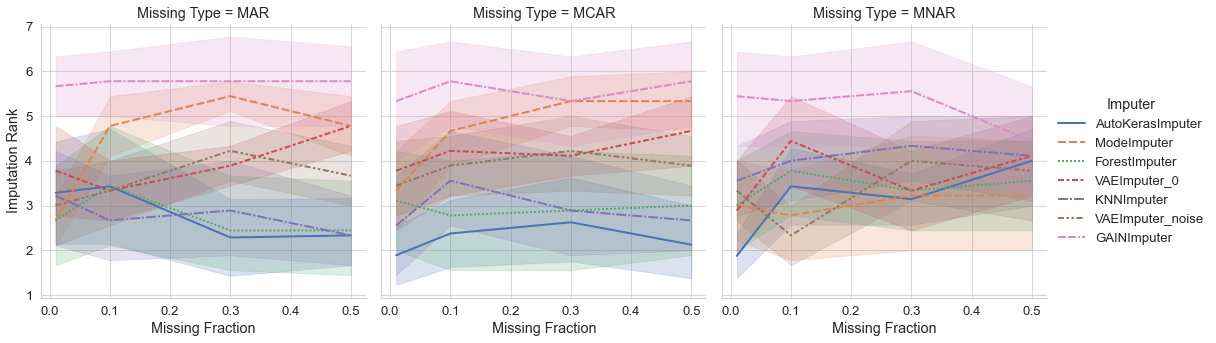

In [34]:
row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([CLF_METRIC]))
plot_data = impute_results[row_idx]

ax = sns.relplot(
    data=plot_data, 
    x="Missing Fraction", 
    y="Imputation Rank", 
    hue="Imputer", 
    style="Imputer", 
    col="Missing Type",
    kind="line",
    ci=CONFIDENCE_INTERVAL
)
#ax.set_xticks(sorted(results["Missing Fraction"].unique()))
plt.gcf().subplots_adjust(bottom=0.15, left=0.05) # avoid x/ylabel cutoff in SVG export
plt.savefig(FIGURES_PATH/IMPUTE_RESULT_TYPE/"categorical_rank_by_type.svg")

### 1.2) Numerical Columns (Regression)

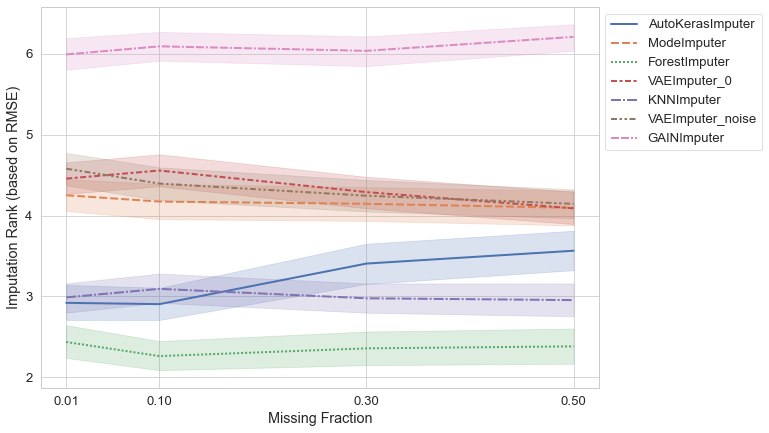

In [35]:
plot_metric_vs_missing_fraction(
    data = impute_results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [REG_METRIC], 
    y = "Imputation Rank",
    ylabel = f"Imputation Rank (based on {REG_METRIC})",
    export_path = FIGURES_PATH,
    figure_name = "numerical_rank"
)

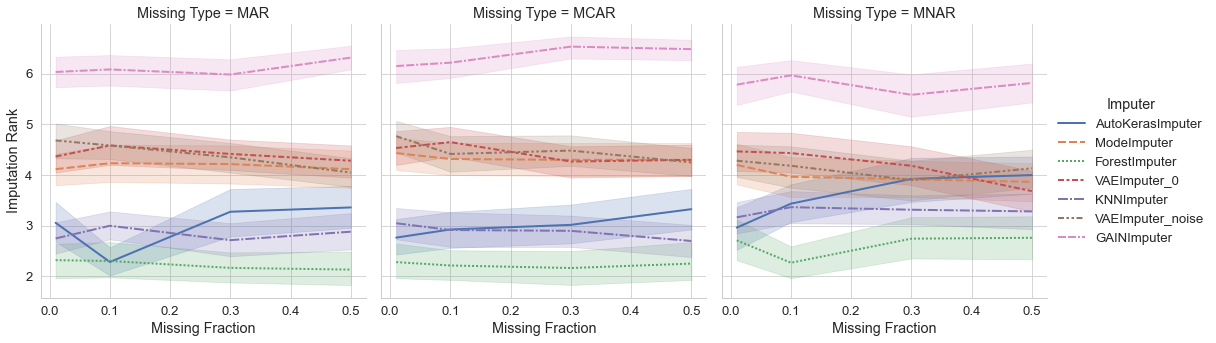

In [36]:
row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([REG_METRIC]))
plot_data = impute_results[row_idx]

ax = sns.relplot(
    data=plot_data, 
    x="Missing Fraction", 
    y="Imputation Rank", 
    hue="Imputer", 
    style="Imputer", 
    col="Missing Type",
    kind="line",
    ci=CONFIDENCE_INTERVAL
)
#ax.set_xticks(sorted(results["Missing Fraction"].unique()))
plt.gcf().subplots_adjust(bottom=0.15, left=0.05) # avoid x/ylabel cutoff in SVG export
plt.savefig(FIGURES_PATH/IMPUTE_RESULT_TYPE/"numerical_rank_by_type.svg")

### 1.3) Heterogenous Columns (Classification and Regression Combined)

In [37]:
row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([CLF_METRIC, REG_METRIC]))
check_data = results[row_idx]
check_data.groupby(["metric"]).size()

metric
F1_macro     737
RMSE        4945
dtype: int64

The data is not equally distributed between categorical and numerical imputation tasks, so simply averaging the ranks, as done in the plots below, could be misleading.

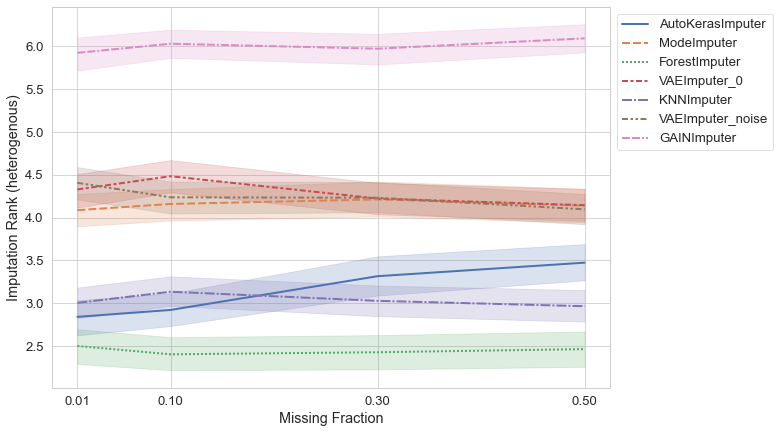

In [38]:
plot_metric_vs_missing_fraction(
    data = impute_results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [CLF_METRIC, REG_METRIC], 
    y = "Imputation Rank",
    ylabel = f"Imputation Rank (heterogenous)",
    export_path = FIGURES_PATH,
    figure_name = "heterogenous_rank"
)

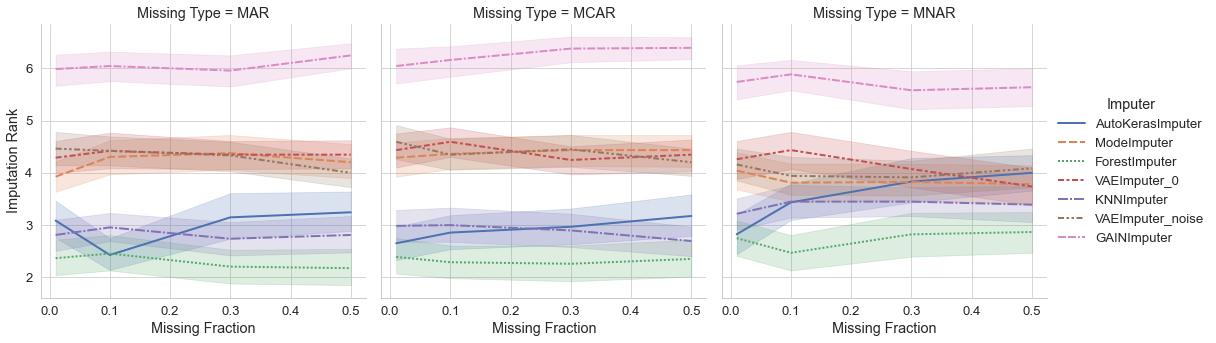

In [39]:
row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([CLF_METRIC, REG_METRIC]))
plot_data = impute_results[row_idx]

sns.relplot(
    data=plot_data, 
    x="Missing Fraction", 
    y="Imputation Rank", 
    hue="Imputer", 
    style="Imputer", 
    col="Missing Type",
    kind="line",
    ci=CONFIDENCE_INTERVAL
)
plt.gcf().subplots_adjust(bottom=0.15, left=0.05) # avoid x/ylabel cutoff in SVG export
plt.savefig(FIGURES_PATH/IMPUTE_RESULT_TYPE/"heterogenous_rank_by_type.svg")